<a href="https://colab.research.google.com/github/lclarete/DHUM72500-FINAL-PORTFOLIO/blob/main/Clarete_Week11_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 11 Notebook
## Supervised Text Classification Algorithms

* Name Livia Clarete
* Date: April 24th 2023
* Class: Methods of Text Analysis


This notebook assignment draws heavily from Chapter 6 of 
[**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler. We will be looking at supervised binary and multiclass text classifications. 


# Chapter 6:<div class='tocSkip'/>

# How to use classification algorithms to label text into multiple categories

## Note from the authors of Blueprints<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. For example we frequently use pretty print (`pp.pprint`) instead of `print` and `tqdm`'s `progress_apply` instead of Pandas' `apply`. 

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

You may also find some lines marked with three hashes ###. Those are not in the book as well as they don't contribute to the concept.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [ ]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch06/setup.py')

%run -i setup.py

You are working on Google Colab.
Files will be downloaded to "/content".
!wget -P /content https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/settings.py
!wget -P /content/data/jdt-bugs-dataset https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz
!wget -P /content/packages/blueprints https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/packages/blueprints/preparation.py
!wget -P /content/ch06 https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/ch06/requirements.txt

Additional setup ...
!pip install -r ch06/requirements.txt


## Load Python Settings<div class="tocSkip"/>


In [ ]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
sys.path.append(BASE_DIR + '/packages')

In [ ]:
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from blueprints.preparation import clean

## What you'll learn and what we will build
This notebook will work through the three fundamental stages of doing supervised machine learning and classification analysis with text. Supervised learning means that we have a dataset with accurate labels to work from, and that we train the model using about 80% of the dataset as "training" data. Then, we test the accuracy of the model on a remaining subset of data (typically about 20% or less). We can validate the model if we have labels for the testing dataset. We're going to learn how to take a dataset and divide it into training and testing sets, to validate the model by evaluating its accuracy, and then applying cross-validation techniques. 

# Introducing the Java Development Tools Bug Dataset
The dataset that we're going to use is a set of bug reports about Java Development Tools. The first classification study will be to see if we can differentiate high priority bug reports from lower priority bug reports. Then, we'll try to classify different types of bug reports. Finally, we'll try to identify what features the bug reports are referring to in order to direct it to the appropriate person for fixing. 

We'll need to import the dataset in the cell below. Then we'll read it in as a csv file and convert it to a Pandas dataframe. To help us understand the way that the data is organized, we'll print out the labels (column headings), and then pull out of the dataframe two random entries. 

In [ ]:
file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)
print (df.columns)
df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


,Issue_id,Priority,Component,Title,Description
38438,239715,P3,UI,No property tester for TestCaseElement for property projectNature,I20080613-2000; ; Not sure if this belongs to JDT/Debug or Platform/Debug.; ; I saw this error message several times today in my error log but Im not yet sure how to reproduce it.; ; -- Error Deta...
44129,395007,P3,UI,[package explorer] Refresh action not available on Java package folders,M3.; ; F5 (Refresh) is available as a context menu entry for ordinary source folders but not for Java package folders in the e4 Java Package explorer.; ; Please restore the 3.x functionality.


## Sample data 
We're going to remove bug reports from the dataset that have been identified as Duplicate issues. In other words, the issue was already discovered and described elsewhere. If we were trying to do summary statistics about the total number of bugs or the rate of response, etc. then we might want to remove all the entries that are reported as duplicates. However, our task is about using the text to predict the priority of a bug--not the speed of response. Since *most* issues are not duplicate issues, what we'll find is that the Duplicate Issue will most often have a null value. So, we can remove that attribute of the data without impacting the reliability of our analysis. 

Take some time to read through a sample from the data. This will help you to better understand what some of the potential problems might be before you start modeling. 

In [ ]:
# we want to thin the dataset out by removing duplicates.  

### df = df.drop(columns=['Duplicated_issue']) - old code ###
df = df.drop(columns=['Duplicated_issue'], axis=1)
pd.set_option('display.max_colwidth', -1)
df.sample(1, random_state=123).T

,11811
Issue_id,33113
Priority,P3
Component,Debug
Title,Evaluating for loop suspends in URLClassLoader
Description,Debug to a breakpoint in some HelloWorld program. In the DisplayView; highlight and ; Display the following code snippet:; ; for (int i = 0; i < 10; i++) {; System.out.println(i);; }; ; Instead of just reporting No explicit return value; the debugger suspends in the ; URLClassLoader; apparently trying to load the class int. You have hit Resume several ; more times before the evaluation completes. The DebugView does not indicate why it ; has stopped (the thread is just labelled Evaluating). This behavior does not happen if ; you turn of the Suspend on uncaught exceptions preference.
Status,VERIFIED
Resolution,FIXED
Version,2.1
Created_time,2003-02-25 15:40:00 -0500
Resolved_time,2003-03-05 17:11:17 -0500


In [ ]:
## Let's see how big the dataset is. Shape tells us the number of rows and columns
df.shape

(45296, 10)

In [ ]:
# Let's do some summary statistics of the dataset as we're getting started
# so that we have a better understanding of how many of each category there is.
df['Priority'].value_counts()

P3    39716
P2    3063 
P4    1143 
P1    1122 
P5    252  
Name: Priority, dtype: int64

<Axes: >

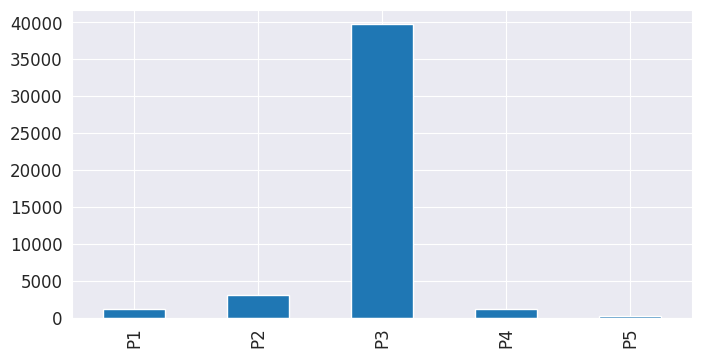

In [ ]:
# It's not always easy to understand how much of a difference there is
# in terms of the amount of data that we're working with, so sometimes
# creating a histogram is helpful for getting a better sense of the proportions
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [ ]:
# Later on, we'll be looking at the prediction of which component is
# involved in the bug report, so let's do some summary statistics of that.
df['Component'].value_counts()

UI       17479
Core     13669
Debug    7542 
Text     5901 
APT      406  
Doc      299  
Name: Component, dtype: int64

<Axes: >

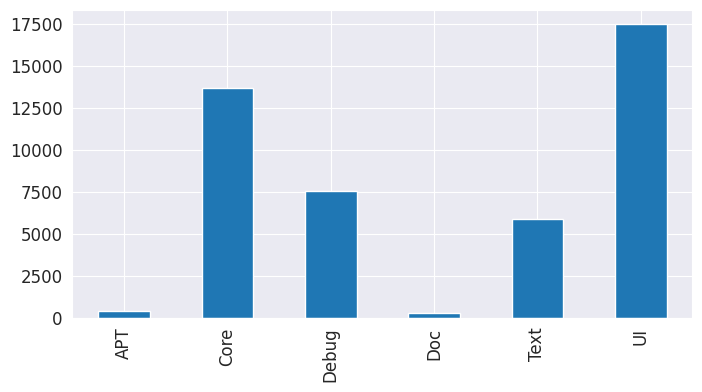

In [ ]:
# While you can see from the summary statistics that APT and Doc are relatively
# fewer in number than other issues, one of the first things we notice is that 
# User Interface (UI) issues are most commonly the ones reported, followed by 
# bugs in the core functionality. 
df['Component'].value_counts().sort_index().plot(kind='bar')

In [ ]:
# This activity does not predict the status of the bug based on the text
# It's good practice to just try to understand the data that you're working with
# But it might be helpful to think about WHY it might not be worth the time trying
# to predict status based on the text. Or would it be worth it?

df['Status'].value_counts()

RESOLVED    28511
VERIFIED    14580
CLOSED      2205 
Name: Status, dtype: int64

In [ ]:
# Again, we don't test for the resolution classification of a bug. 
# But as you go through the supervised learning activities, would this be a
# category worth testing? Why or why not?
df['Resolution'].value_counts()

FIXED          22750
DUPLICATE      7688 
WONTFIX        5126 
WORKSFORME     5094 
INVALID        3117 
NDUPLICATE     1248 
NOT_ECLIPSE    273  
Name: Resolution, dtype: int64

## Question: 
These are not the only questions you might want to ask of yourself or of the dataset before you get started. What are some of the other questions to ask? Based on what you know already from vectorizing and doing cosine similarities, what kinds of phenomeonon in the data might impact the outcome? What are some of the things that you would recommend we do when preparing the data to a.) improve the accuracy of the model and b.) reduce the computing resources needed to do it? 

Consider, for example, that ecological impacts of large language models are a feminist concern, especially as changes in climate are proving most devastating to women and to countries in the Global South where the impact of climate change is felt most immediately. 

## Answer

Can be answered using crosstabs and correlation analysis
* What is the status, resulution, and Priority of each Component? It will help to asses the most urgent categories that are left behind by the resolution team.

* What are the main factores pushing the Priority variable? 


Can be answered using text classification
* What are the commom themes and patterns in the bug report? It will help to label the most recurrent bugs and the underlying causes of issues.

* The letter question will help to answer if there are particular features on Java development to are more prone to create issues.

Environimental: language models on the environment and social justice
* Cleaning and standardizing the text data, removing irrelevant or redundant information

* Using methods for reducing the dimensionality of the data, such as PCA, and feature selection

* Extracting relevant features to imporove the model to use, and optimizing the model

# Blueprint: Building a Text Classification system

Ok, now we know a little bit about the dataset that we're working with. We know how many dimensions it has. We know the basic proportions of several features, including Priority, Component, Status, and Resolution. 

In the next section of the notebook, we're going to work deliberately through three steps in supervised text classification. This is a blueprint or workflow that can be reproduced (with adaptations based on the dataset you're working with) for a variety of other similar kinds of text classification analyses. 

After we go through building a text classification system in three steps, we'll go back over the process from start to finish as a coherent workflow. 

## Supervised Learning
Text classification is one form of machine learning (ML) that falls under supervised learning. As we learned from reading Meredith Broussard, supervised learning requires that we have a dataset with labeled data points. We use that data and through computational processes that compare features of each observation, the machine develops a prediction as to which features from the data are most likely related to the labels associated with it. The output of the training set is a model. In the model we are about to create, we will use independent text variables, such as title and description to predict the priority or the component associated with it. 

A supervised machine learning method maps a function from the input to the output based on calculating statistical likelihoods that there is a relationship between variables. That, ultimately, is what we're defining as "learning." 

Of course, we have to know whether or not the model is reflective of what we would be satisfied to call "reality" or "true." Therefore, we divide the process in two components. First, we "train" the model, which means we use the largest amount of data and labels so that the computer comes up with predictions of the relationships between the text and the label we assigned to it. Next, we use a smaller subset of the same data to test how accurate the model's predictions are. The more features we add to the model, presumably, the more likely we are to get accurate results. In other words, if we know more than Priority, but also the day of the week that the bug report is submitted or the time of day... by increasing the density of the feature vector (remember from our vectorizing assignments), the idea is that we improve the liklihood that the model "trained" will be accurate (which is to say reflected of our expected reality). 

## How it works
During the training phase, we take text documents and their associated labels and we create vectors that both describe the text and include the presence or absence of the labeled features. The computer runs those vectors through statistical processes that calculate the likelihood that relationships between vectors exist. The output is a model that includes various statistical predictions. 

The next step is that we take new text data and we feed the text vectors--this time without the labels--to the trained model. Then we use the model to output the statistical likelihood that that the text is associated with each of the labels based on what it "learned" during the first phase. 

We can then predict the accuracy with which the model is able to predict the relationship between a text document and a label by comparing the predictions to the actual labels of the tested dataset. 

## Types of Supervised Text Classification

- *Binary Classification* means that based on multiple features text is marked as either having the feature or not having it. For example, whether an email is spam or not spam. (But it can't tell you if that email is one more of those newsletters your friends send out regularly that you simply don't have time to read but that your friend is going to ask you about when you see them next time.... sorry... that one's on you.) 

- *Multiclass Classification* is when each observation is associated with only one label out of several options. 

- *Multilabeled Classification* is when each observation ould be assocaited with multiple labels. 





## Step 1 - Data Preparation
First, we're going to reduce the number of columns in the statset to just the title, description, and priority. If any of the observations in each of those entries has no data, then we want to remove that entry from the dataset. Then, we want to combine the title and the description text into one lump. That means that the dataframe turns into just 2 columns that are "priority" and "text."  

In [ ]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

We've gone over steps in cleaning data in previous weeks, so we're going to import some of those cleaning processes here to streamline things. Then we're going to only keep the data with a string longer than 50 characters. That's easy to do because there's enough data in the dataset without the smaller documents and the more text there is in the issue the better chance we have of correlating it to an accurate label. 

In [ ]:
from blueprints.preparation import clean
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

,Priority,text
42439,P3,Regression in TypeHierarchyPerfTest#testOpenObjectHierarchy() I20110329-0800; ; http://download.eclipse.org/eclipse/downloads/drops/I20110329-0800/performance/eplnx2/Scenario415.html; ; The regression can be seen on all platforms.; ; Also TypeHierarchyPerfTest#testOpenCollHierarchy() shows erratic behavior on all platforms.
30486,P3,introduce indirection: misleading warning about duplicate method 3.2 M5 testing; ; have two classes; Foo and Bar; Foo with method m; refactor introduce indirection on m; warning: duplicate method m in declaring class (ok); change declaring class to Bar; ; the warning is still there; despite that Bar does not contain any methods; expected: the warning goes away as the declaring class is changed


## Step 2 - Train-Test Split
Fortunately, there are packages for machine learning that will help you to divide a dataset into two groups: a larger group to train the model and a smaller set to test it. 

In the following step, we're creating multiple variables. In other words, we need to split into 80% training data and 20% testing data. We also need to specify which are our independent and our target variables. In this case, "text" is our independent variable, because it is the one that can change. The target variable is the one we will ultimately test for. That's why we have an X train (text) and a X test (priority) and a Y train (text) and a Y test (priority). We designate that we want the test_size to be 20% (in decimals) and then we set a random state, which is simply something the computer needs to begin a random selection process. Changing the random state should not change the outcome of the model if the model is accurate; however, if you were to change the random_state variable, you are likely to come up with a different composition of testing and training datasets. Finally, we use `stratify` to make sure that we're selecting proportionately among the various priority labels. At this point, we just want to know if data is a priority or not. We don't want to bias the model by skewing it toward one priority type. (Note: we'll come back to this later). 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


## Step 3 - Training the machine learning model

The next step should be familiar. We need to vectorize the text using the tf-idf vectorizer (which means that we want to make sure that words that appear very frequently and not frequently at all do not skew the model). 

In [ ]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

Then we're going to use "support vectors" to train a model. Linear SVM is a very popular text classification algorithm. In this model, the computers uses the relationships between vectors to create a line where there is the greatest separation between two classes. There may be more than one possible line. The algorithm chooses the line that provides the maximum separation between the closest points in two classes. Because the computer needs to know where to start its random process of evaluating vectors, we have to set a `random_state`. The tolerance level is how much room for error we are willing to live with. In this case, it is input in scientific notation, and a much simpler way of indicating 0.00001. 



In [ ]:
# The output of the LinearSVC (Lindear Support Vector Classification) is a 
# model file, which is an object with multiple components. The model itself
# isn't instructive or useful until we evaluate it and apply it to tasks.
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

## Step 4 - Model Evaluation
We're going to spend more time thinking about evaluation during the last few weeks of class. It's important to go through these steps and to know what they do. It's impossible to completely separate any of these steps in the process. However, just note that we'll come back to this concept in coming weeks and spend more time on what it means to evaluate and analyze. Suffice it to say, analysis and evaluation are required at every and all stages of the process. 

In [ ]:
# Now we want to take the test dataset and we're going to use it
# to evaluate how accurately the model can predict whether text is
# associated with a priority or not. Notice we are skipping the fit
# step and going straight to vectorizing. In other words, we are not 
# asking the model to learn new vocabulary. 
X_test_tf = tfidf.transform(X_test)

In [ ]:
# We evaluate how well the model did by running the predict method on the X test 
# sample of data and then compare the predicted values to the actual labels. 
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


### Results
The accuracy score is a proportion and can be interpreted as a percentage. In other words, there's an 87.6% (give or take) likelihood that the model will be abe to predict whether or not the text is associated with a Priority label. It's a good idea to consider whether or not the accuracy is more or less likely than other methods of estimating. For example, is it better than the odds of tossing a coin and getting it right? (better than 25%) Or, could you roll a dice and get a better likelihood of the right answer? 

So, one way to do this is to compare the result to something more naive like the DummyClassifier, where the baseline model always predicts the class with the highest frequency or that is "stratified" which is to say it makes predictions based on the proportion of labels in the training dataset. 

In [ ]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=42, strategy='most_frequent')

Accuracy Score -  0.8769281988680502


Uh oh. Hold on a second... what we discover when we do this is that the trained model isn't actually predicting based on what we imagined to be other features. In other words, the model is accurate as often as if we assigned all the text with the P3 class... We might also want to go in and imagine how well the model is performing depending on the various priority levels. 

To do that, we can build something called a *confusion matrix*. In a [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62), we compare the actual values with the predicted values. 





In this case, the actual values are Priority P3 and Not P3 (P1+P2+P4+P5). The Predicted values are also Priority P3 and Not P3 (P1+P2+P4+P5). 

* True positive: the actual label and the predicted label P3 are both correct. 
* False positive: assigning text to any label that is not P3 is correct. 
* False negative: The number of times the text was predicted to be not P3 but in reality it was P3.  
* True negative: The number of times the model precicts correctly that the text is not P3. 



### Precision and Recall
What makes a confusion matrix useful is that we can use this matrix of numbers to measure the proportion of predicted positives that were actually positive, which is another measure of how accurate the predictions are. 

Precision is the number of times the model correctly predicts a variable to be in a category, divided by the total number of accurate predictions. 

Recall is the number of times that the model makes the right class assignment (true positive) divided by the number of times it is completely correct and completely incorrect (True positive + false negative). 


In [ ]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

The problem is that we're not just testing for one label. We've got a multi-class question. There's not just one priority label. There are 5, and they are not equally represented in the data. So, while the model correctly predicts that there is a high priority for P3, it does not differentiate between classes of priority. 

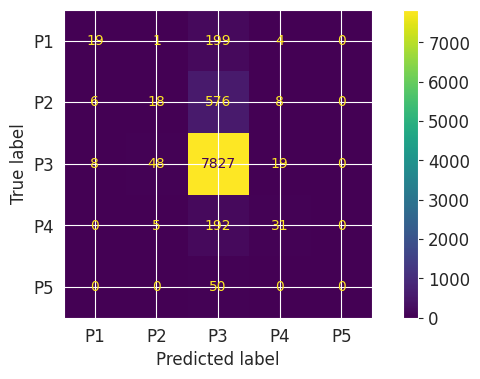

In [ ]:
## Old code:

# plot_confusion_matrix(model1,X_test_tf,
#                       Y_test, values_format='d',
#                       cmap=plt.cm.Blues)
# plt.show()

## New code:

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



### Class Imbalance
Ultimately, the challenge is that the dataset has a much higher proportion of data labeled P3 than any other label. This is going to skew the predictions, because the most likely label is often the most frequent label. But frequency is only one feature out of many. 

Feature engineering includes figuring out how to adjust the input into the model to better reflect what you want it to focus on. So, for example, if we want it to consider that P3 is common, but not completely determine the model based on frequency, then we could choose to either adjust down the amount of P3 labeled data that we include in the model--called *downsampling*, or inversely, we could increase the amount of data with other labels (*upsampling). 

For our example, we're going to bring the amount of P3 data down so that it remains the largest category, but it is not purely size that will determine the model's output. When we downsample, we are losing information. If your dataset is already small, this may not be the best choice. If you are upsampling, then you are adding or repeating existing data. That will also impact data quality and lead to compromise. 



In [ ]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['Priority'].value_counts()

P3    4000
P2    3038
P4    1138
P1    1117
P5    252 
Name: Priority, dtype: int64

# Final Blueprint for Text Classification

Ok, so now that we've done each of these steps one time, let's go back and start the process over making adjustments to our model to reflect what we've learned about the data. We're going to turn this into a multiclass classification model. We've downsampled data labeled P3 so that frequency is not overdetermining the result. 

Despite the fact that the first model had a very high "accuracy" score, what we realized is that it wasn't actually a good model because it wasn't doing anything more than identifying all data as likely to be associated with the most frequent label. 

Now, we're going to try to create a new model that can predict whether an issue is a priority based on which of the labels it is most likely to be associated with. 

In [ ]:
# Loading the balanced dataframe

df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7636
Size of Test Data  1909


LinearSVC(random_state=0, tol=1e-05)

Accuracy Score -  0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



So the new accuracy score for the model overall now is about 50% (it won't be the same for everyone because it's based on probabilities, but the difference won't be more than 1% up or down). The precision and recall values for P1 and P2 are better, but it completely misses the 50 bugs that had been labeled P5. 

Nevertheless, even though the model's accuracy score is lower, it is a better model overall because the predictions are more reflective of the input. And, what we learn, is that this isn't really going to be helpful for generating predictions in the future. In other words, if we run the DummyClassifier on the stratified data, we'll discover that simply making predictions about what priority label a bug report receives could be randomly assigned based on the overal proportions of each label in the dataset... and it would be just as accurate. 

In [ ]:
clf = DummyClassifier(strategy='stratified', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='stratified')

Accuracy Score -  0.31691985332634887


Perhaps the whole exercise isn't a total loss, though, because we can go through and see places where the model was accurate and inaccurate and maybe there's something you can uncover about the quality of the data that is causing it to be problematic. Perhaps the results would change if you were to remove stopwords or symbols or numbers. 

In [ ]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
8461,Variable view show old instance using build 20020917; ; Step to reproduce:; 1) create a selfhosting workspace (20020917).; 2) put a breakpoint in CompletionEngine at line 774 ; CompilationUnitDeclaration parsedUnit = parser.dietParse(...).; 3) create a launch configuration Runtime Workbench.; 4) launch this configuration in debugger.; 5) create a Java project.; 6) create a class.; 7) do ctrl+space in editor to hit breakpoint.; 8) look the id of the parser field of CompletionEngine in the variable view .; 9) step into parser.dietParse(...).; 10) in variable view the id of the parser is the same as step 8.; 11) do resume.; 12) do ctrl+space in editor to hit breakpoint.; 13) the id of the parser field is the same as step 8 (but it should not be the ; same instance of CompletionParser).; 14) step into parser.dietParse(...).; 15) the id of parser is a new id (as expected).; ; It seems that variable view doesnt show the right instance in the step 13.,P1,P1
34854,model proxy created for Java debug target in var view While investigating bug 177910; I found that the deltas for thread creation were duplicated in the output produced by Walter. I discovered that two model proxies are created for Java debug targets because the JavaModelProxyFactory does not limit the creation of proxies for targets to the debug view (as it should).,P2,P2


In [ ]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=33)

,text,actual,predicted
40065,Too many semicolons after constructor completion I20090611-1540; ; public class Try {; Object m() {; return null;; }; }; ; select null; type new Runna; Ctrl+Space; press Enter to select the anonymous proposal for Runnable(); ; => Result:; ; public class Try {; Object m() {; return new Runnable() {; ; public void run() {; // TODO Auto-generated method stub; ; }; };;;; };,P2,P3
7178,Next/Previous buttons have double image 20020606 XP; ; 1) Open Java editor; Outline; Search view; 2) Click in editor; click in outline; click in search; 3) Note that the show previous/ show next buttons have a double image.; Hover over the button and the imgae is corrected,P2,P3


# Cross-Validation
The accuracy of the model that we created is somewhere around 48.7%, which is just under a coin's toss likelihood of being correct. That's not great. There are a number of steps we could take to try to improve the model from here: 
- add features like trigrams
- add additional text cleaning steps
- tweak the model's parameters and then check for performance on the test split. 

One way to test whether or not the results are an artifact of the random selection of data and the shuffling of data order could be to set a new `random_state` which would shuffle the data and could result in a different accuracy outcome. We won't know until we try. 

Cross-validation is when we train a model on different splits of the data and validate on different splits of data so that the model achieves a balance between *underfitting* and *overfitting*. Underfitting happens when the  model is complex and has fit the underlying pattern well during training but produces significant deviations during the testing phase. In this case, the model has been trained too narrowly on the data and doesn't do a good job of generalizing on new data. 

We can build cross-validation into the classification pipeline using something called K-fold validation. This is a formula, essentially, for selecting different cross sections of data and then returning validation scores for each "fold" or iteration of the split. 

In [ ]:
# Vectorization

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()

# Cross Validation with 5 folds

scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df['Priority'],
                         cv=5)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.48192771 0.45311682 0.43949712 0.42221058 0.37297014]
Mean value across of validation scores  0.43394447354635934
Standard deviation of validation scores  0.036211476115013436


# Hyperparameter Tuning with Grid Search
Grid-search is a tool that we can use to improve a model's accuracy by systematically evaluating the parameters of the arguments we feed to the model. The process includes trying out different combinations of *hyperparameters* to improve the desired output. [Hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning) set the boundaries of the "learning" process. When we use grid-search, we provide a set of parameter values that we can evaluate. Combining this with cross-validation will help to identify the hyperparameters that are impacting the model and provide clues as to where to make adjustments to improve the accuracy of the results. 

To begin, a `training_pipeline` defines the steps that we would like to run. The following example specifies tf-idf vectorization and the LinearSVC model from scikit-learn. Then, the `grid_param` argument allows us to define the parameters that we want to test. Parameters are specific to each phase in the pipeline, so we use the name of the phase as a prefix to specify what we're testing for. So, for example, min_df is a parameter, so we call it `tfidf_min_df`. In the last phase, we call the GridSearchCV method, which automates the process of testing multiple versions of the entire piepline with different sets of hyperparameters and produces a cross-validation score for each. That allows us to pick the best performing pipeline and model. 

The following step will take a bit of time. Be sure that you can let the process run without the notebook disconnecting so that it can finish. 

In [ ]:
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(
        stop_words="english")), ('model',
                                 LinearSVC(random_state=21, tol=1e-5))])

grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LinearSVC(random_state=21,
                                                  tol=1e-05))]),
             param_grid=[{'model__loss': ['hinge'], 'model__max_iter': [10000],
                          'model__penalty': ['l2'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [1, 10], 'model__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.4597171293871137


In [ ]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
2,1,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}"
0,2,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}"
1,3,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}"
3,4,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 6)}"
4,5,0.44,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}"


# Reviewing what we've done and an extended pipeline with optional components

The activity below is very resource intensive, and if you are running it on your local desktop computer or with the free Google Colab account it will take a prohibitively long time to do. As a result, my request is that you read through the code below as the bare minimum. Running the final cells for this is not required. There are activities below these next 4 cells, though, that you are expected to complete. 


---



---



Using what we've learned so far, let's go through the whole process of doing a multiclass text classification analysis using supervised learning and support vector classification. This time, let's identify the priority of the bug so that we can assign it to the appropriate development team (ie. consider a real world task to apply). Ideally, we would be able to do this automatically by using a classification model to determine which component of the software the bug report is referring to. All the bug reports have a feature called "Component" and values in that feature include Core, UI, and Doc. 

To complete this new task, we need to make the following changes: 
- add a step to include a grid-search that identifies the best hyperparameters and limts the number of options tested to increase runtime. 
- add an option t ouse the sklearn.svm.SVC function in order to compare the performance of this model to the LinearSVC. 


In [ ]:
# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True

# Loading the dataframe

file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)
df = df[['Title', 'Description', 'Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Description']
df = df.drop(columns=['Title', 'Description'])

# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Component'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Component'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")

if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)

gridSearchProcessor.fit(X_train, Y_train)

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Step 4 - Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7208
Size of Test Data  1802


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid=[{'model__C': [1, 100], 'model__kernel': ['linear'],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

Best alpha parameter identified by grid search  {'model__C': 1, 'model__kernel': 'linear', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}
Best result identified by grid search  0.7358510088444129
Accuracy Score -  0.7386237513873474
              precision    recall  f1-score   support

         APT       1.00      0.31      0.48        16
        Core       0.75      0.78      0.76       545
       Debug       0.90      0.77      0.83       300
         Doc       0.67      0.33      0.44        12
        Text       0.65      0.47      0.54       235
          UI       0.70      0.81      0.75       694

    accuracy                           0.74      1802
   macro avg       0.78      0.58      0.63      1802
weighted avg       0.74      0.74      0.73      1802



In [ ]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='most_frequent')

Accuracy Score -  0.3851276359600444


In [ ]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred } 
result = pd.DataFrame(frame)

result[result['actual'] == result['predicted']].sample(2, random_state=21)

,,text,actual,predicted
2,43535,Cant remove breakpoint from breakpoints viewClicking on the Remove selected breakpoints button in the Breakpoints view is not removing any breakpoints.; ; I dont know if the is a JDT debug problem or a platform debug problem. I only have Java breakpoints; so I am raising the bug on JDT.; ; Using Eclipse 4.2M6,Debug,Debug
1,36831,Need to have local bindings created in error casesI20071113-0800; ; The following example shows that resolution of QualifiedAllocationExpression aborts to early and local type binding are not created. This is needed for bug 210070.; ; import java.io.Serializable;; ; public final class X implements Serializable {; ; void bar() {}; ; interface IM {}; class SMember extends String {}; ; @Annot(value = new SMember()); class Member extends X ; ZorkMember z;; void foo() {; this.bar();; Zork1 z;; ; }; ; @Annot(value = ; new X(){; ZorkAnonymous1 z;; void foo() {; this.bar();; Zork2 z;; }; }); void foo() {; new X().new IM();; class Local extends X ; ZorkLocal z;; void foo() {; this.bar();; Zork3 z;; }; }; new X() {; ZorkAnonymous2 z; ; void foo() {; this.bar();; Zork4 z;; }; };; }; }; @interface Annot {; String value();;,Core,Core


In [ ]:
result[result['actual'] != result['predicted']].sample(2, random_state=42)

,,text,actual,predicted
1,3913,Code formatter should have option for not indending methods and fieldsBuild 20020228; ; The code formatter should have an option to avoid indenting members of the ; outermost class (you would still want to indent members of nested classes).; This was raised as a feature request at the TC; and its one Id also like to ; see. (I couldnt find an existing PR for it.),Core,UI
2,221,Ctrl-S does not work in the SnippetEditor (1GL1GH8)DS (10/3/01 3:58:22 PM); CTLR-S does not save in the snippet editor.; Should just add the snippet save action to the edit menu of the workbench like; the Java Editor; ; NOTES:,Debug,UI


# Reviewing what we've done
The activities in this notebook demonstrate a generalizeable approach to doing text classification analysis with SVC algorithms. We move from data preparation through data splitting into training and testing, and then we used cross-validation methods to evaluate the accuracy of the model and to validate the verious hyperparameters that would produce an optimal model. We also found that the accuracy score alone might not be the best measure of the "best" iteration of the model that we produce. We learned that understanding the data an making informed interpretations throughout the pipeline is a critical part of the process. 

# Reflection Activity

Now that you've gone through the process of developing a supervised model for classifying text, are there parts of the process that you feel could be concerning for feminist scholarship? What are the opportunities? 

Thinking through the steps of the process, what kinds of questions should feminist scholar
s who are interested in doing classification analysis consider as they prepare data for analysis? As they evaluate the accuracy of the model? As they consider testing the model? 

Finally, what might be some of the opportunities or concerns be for feminist scholars who are interested in using a classification model workflow like this to make predictions about new data? 

## Answer

Feminist scholarlars concerns:

* Data collection: even though it's not part of the data process and analysis pipeline, quality data is the building block for a quality analysis. Ideally, the data should be unbiased, diverse and representatively collected and sellected into this dataset

* How can we ensure that the model is not perpetuating existing biases or contributing to social inequalities in the Java working place? Are any type of issue opened by a certain type of users due to lack of traning?

* Ethical issues: assess if the implications of using classification models outweigh the potential harms, making sure the results are implemented to improve the user's experience, and exployees experience.

Step process:
* Increased efficiency: What is the most efficient model to be used in this analysis? It's still hard to measure the amount of energy used to run each line, but we can use time processing to evaluate the best model. We can perform the analysis with a sample to asses the higher cost benefit, then running the full analysis with the optimized model. 

Opportunities:
* Create KPI efficiency metrics to help guide practitioners and accademics to better user of language model